In [11]:
# Phase 1: Data Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv(r"C:\Users\smadu\OneDrive\Desktop\INF 791 Applied Data Science\Assignment 01\bank-full(1).csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
## 1.1 Data Cleaning
#We start by identifying missing values (NaN) and placeholder values such as 'unknown' in the dataset. We summarize the number of such values in each column and explain the strategy for handling them.

           missing  unknown  total_problematic
job              0      288                288
marital          0        0                  0
education        0     1857               1857
default          0        0                  0
housing          0        0                  0
loan             0        0                  0
contact          0    13020              13020
month            0        0                  0
poutcome         0    36959              36959
y                0        0                  0


In [12]:
# Identify missing and 'unknown' values
missing_summary = pd.DataFrame({
    'missing': df.isnull().sum(),
    'unknown': (df == 'unknown').sum(),
    'total_problematic': df.isnull().sum() + (df == 'unknown').sum()
})
print(missing_summary)

# Strategy: Replace 'unknown' with NaN, then drop rows with any NaN for simplicity and data quality
df_cleaned = df.replace('unknown', np.nan)
df_cleaned = df_cleaned.dropna()
print(f"Rows after cleaning: {df_cleaned.shape[0]}")
df_cleaned.head()

           missing  unknown  total_problematic
age              0        0                  0
job              0      288                288
marital          0        0                  0
education        0     1857               1857
default          0        0                  0
balance          0        0                  0
housing          0        0                  0
loan             0        0                  0
contact          0    13020              13020
day              0        0                  0
month            0        0                  0
duration         0        0                  0
campaign         0        0                  0
pdays            0        0                  0
previous         0        0                  0
poutcome         0    36959              36959
y                0        0                  0
Rows after cleaning: 7842


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
24060,33,admin.,married,tertiary,no,882,no,no,telephone,21,oct,39,1,151,3,failure,no
24062,42,admin.,single,secondary,no,-247,yes,yes,telephone,21,oct,519,1,166,1,other,yes
24064,33,services,married,secondary,no,3444,yes,no,telephone,21,oct,144,1,91,4,failure,yes
24072,36,management,married,tertiary,no,2415,yes,no,telephone,22,oct,73,1,86,4,other,no
24077,36,management,married,tertiary,no,0,yes,no,telephone,23,oct,140,1,143,3,failure,yes


In [13]:
## 1.1 Feature Categorization
# We categorize each feature as either numerical or categorical. The table below lists each feature, its type, and a brief description.

In [14]:
# Categorize features
feature_types = pd.DataFrame({
    'feature': df_cleaned.columns,
    'type': ['numerical' if np.issubdtype(df_cleaned[col].dtype, np.number) else 'categorical' for col in df_cleaned.columns],
    'description': [
        'Client age', 'Job type', 'Marital status', 'Education level', 'Default on credit', 'Average balance', 'Has housing loan',
        'Has personal loan', 'Contact communication type', 'Last contact month', 'Last contact day', 'Duration of last contact',
        'Number of contacts during campaign', 'Days since last contact', 'Number of previous contacts', 'Outcome of previous campaign',
        'Subscribed to term deposit'
    ]
})
feature_types

,feature,type,description
0,age,numerical,Client age
1,job,categorical,Job type
2,marital,categorical,Marital status
3,education,categorical,Education level
4,default,categorical,Default on credit
5,balance,numerical,Average balance
6,housing,categorical,Has housing loan
7,loan,categorical,Has personal loan
8,contact,categorical,Contact communication type
9,day,numerical,Last contact month


In [15]:
## 1.2 Feature Engineering: New Features
# We create two new features to enhance model performance. Each feature is explained below.

In [16]:
# Feature 1: Age Group
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=[17, 30, 45, 60, 100], labels=['Young', 'Adult', 'Senior', 'Elder'])
# Purpose: Groups clients by age for better segmentation. Age group may influence likelihood to subscribe.

# Feature 2: Contacted Before (binary)
df_cleaned['contacted_before'] = np.where(df_cleaned['previous'] > 0, 1, 0)
# Purpose: Indicates if client was previously contacted. Prior contact may affect subscription probability.

# Display sample of updated data
df_cleaned[['age', 'age_group', 'previous', 'contacted_before', 'y']].head()

,age,age_group,previous,contacted_before,y
24060,33,Adult,3,1,no
24062,42,Adult,1,1,yes
24064,33,Adult,4,1,yes
24072,36,Adult,4,1,no
24077,36,Adult,3,1,yes


In [17]:
## 1.3 Basic Statistics and Correlation Analysis
# We compute summary statistics for numerical features and analyze correlations to guide feature selection and modeling.

                   count         mean          std     min    25%    50%  \
age               7842.0    40.783856    11.282964    18.0   32.0   38.0   
balance           7842.0  1552.343280  3084.580003 -1884.0  162.0  595.0   
day               7842.0    14.260010     7.885328     1.0    7.0   14.0   
duration          7842.0   261.290615   236.203272     5.0  113.0  194.0   
campaign          7842.0     2.064269     1.566109     1.0    1.0    2.0   
pdays             7842.0   223.252869   111.830127     1.0  133.0  195.0   
previous          7842.0     3.184264     4.614190     1.0    1.0    2.0   
contacted_before  7842.0     1.000000     0.000000     1.0    1.0    1.0   

                      75%      max  
age                 47.00     89.0  
balance           1733.75  81204.0  
day                 20.00     31.0  
duration           324.00   2219.0  
campaign             2.00     16.0  
pdays              326.00    871.0  
previous             4.00    275.0  
contacted_before   

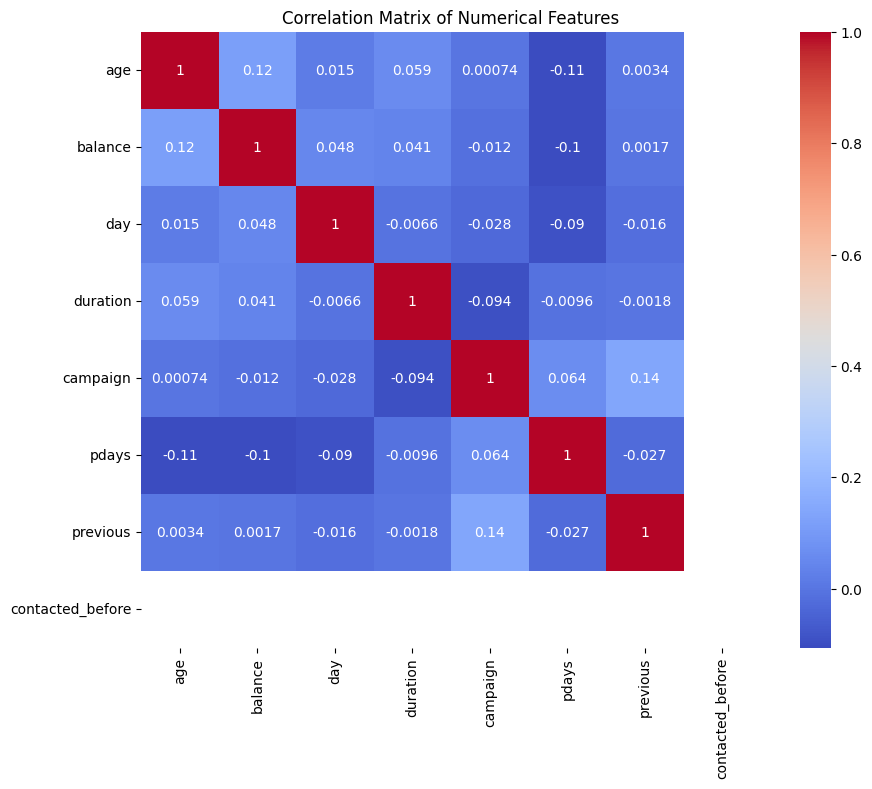

In [18]:
# Summary statistics for numerical features
num_features = df_cleaned.select_dtypes(include=[np.number]).columns
summary_stats = df_cleaned[num_features].describe().T
print(summary_stats)

# Correlation matrix
corr_matrix = df_cleaned[num_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [19]:
## 1.4 Data Visualisation
# We use histograms, bar charts, boxplots, and heatmaps to explore data distributions and relationships with the target variable.

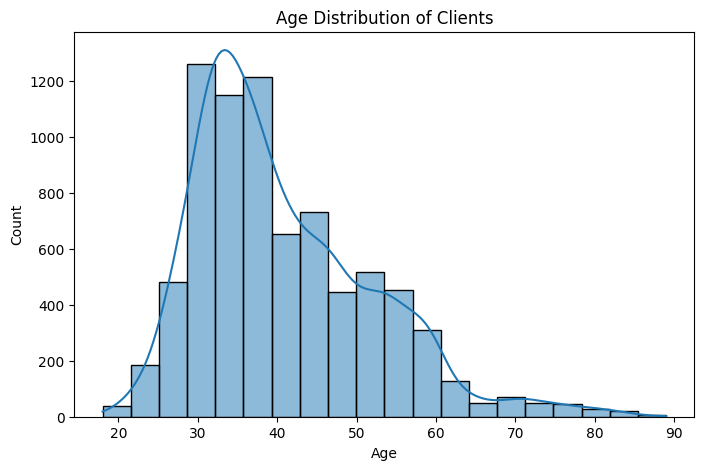

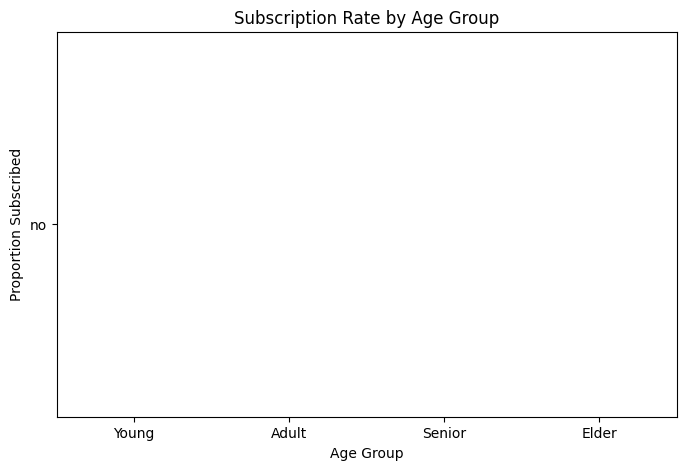

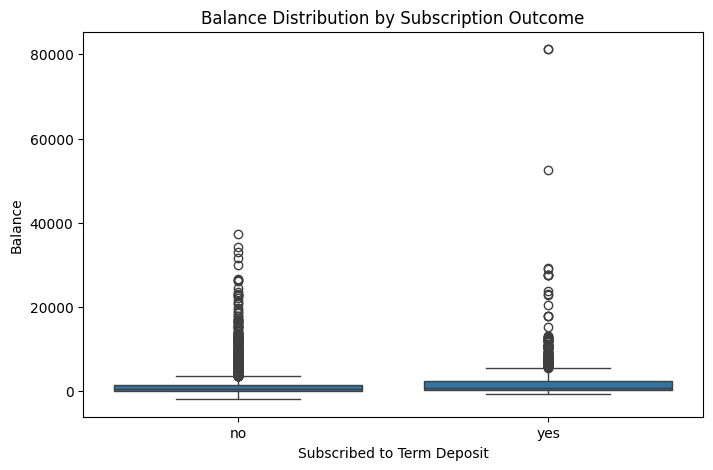

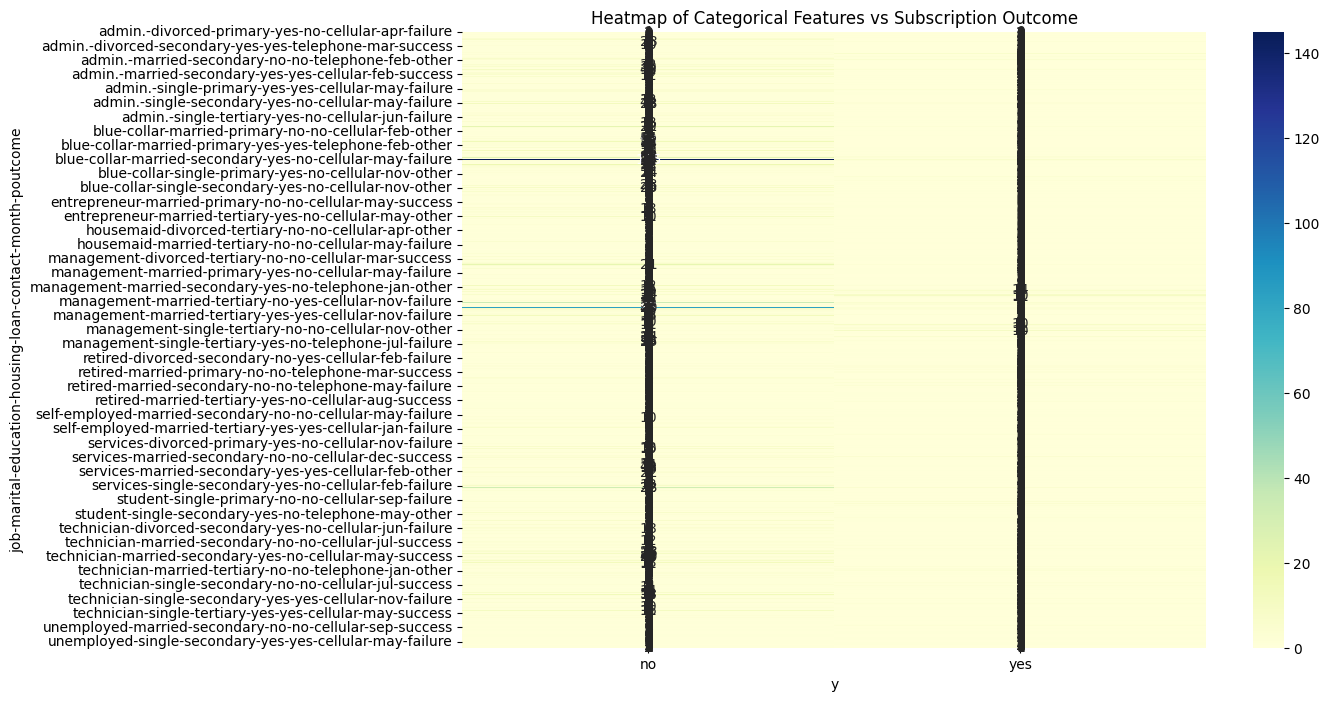

In [20]:
# Histogram of Age
plt.figure(figsize=(8,5))
sns.histplot(df_cleaned['age'], bins=20, kde=True)
plt.title('Age Distribution of Clients')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Bar chart: Subscription rate by Age Group
plt.figure(figsize=(8,5))
sns.barplot(x='age_group', y='y', data=df_cleaned, estimator=lambda x: np.mean(x=='yes'))
plt.title('Subscription Rate by Age Group')
plt.ylabel('Proportion Subscribed')
plt.xlabel('Age Group')
plt.show()

# Boxplot: Balance by Subscription Outcome
plt.figure(figsize=(8,5))
sns.boxplot(x='y', y='balance', data=df_cleaned)
plt.title('Balance Distribution by Subscription Outcome')
plt.xlabel('Subscribed to Term Deposit')
plt.ylabel('Balance')
plt.show()

# Heatmap: Categorical features vs Target
cat_features = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'poutcome']
pivot = pd.pivot_table(df_cleaned, index=cat_features, columns='y', aggfunc='size', fill_value=0)
plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Heatmap of Categorical Features vs Subscription Outcome')
plt.show()

In [21]:
## 1.5 Data Preprocessing: Additional Data Transformations
# We drop irrelevant features, ensure consistent data types, and prepare the final dataset for modeling.

In [22]:
# Drop 'duration' (leakage-prone) and other irrelevant columns if needed
df_model = df_cleaned.drop(['duration'], axis=1)
# Convert categorical columns to string type for encoding
for col in df_model.select_dtypes('object').columns:
    df_model[col] = df_model[col].astype(str)
# Check final structure
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7842 entries, 24060 to 45210
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               7842 non-null   int64   
 1   job               7842 non-null   object  
 2   marital           7842 non-null   object  
 3   education         7842 non-null   object  
 4   default           7842 non-null   object  
 5   balance           7842 non-null   int64   
 6   housing           7842 non-null   object  
 7   loan              7842 non-null   object  
 8   contact           7842 non-null   object  
 9   day               7842 non-null   int64   
 10  month             7842 non-null   object  
 11  campaign          7842 non-null   int64   
 12  pdays             7842 non-null   int64   
 13  previous          7842 non-null   int64   
 14  poutcome          7842 non-null   object  
 15  y                 7842 non-null   object  
 16  age_group         7842 n

In [23]:
## 1.6 Data Encoding
# We apply one-hot encoding to nominal categorical variables and ensure all features are numeric for modeling.

In [24]:
# Identify nominal categorical variables
nominal_cols = [col for col in df_model.columns if df_model[col].dtype == 'object' and col != 'y']
# Apply one-hot encoding
df_encoded = pd.get_dummies(df_model, columns=nominal_cols, drop_first=True)
# Encode target variable
df_encoded['y'] = (df_encoded['y'] == 'yes').astype(int)
# Check final structure and data types
print(df_encoded.info())
df_encoded.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7842 entries, 24060 to 45210
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  7842 non-null   int64   
 1   balance              7842 non-null   int64   
 2   day                  7842 non-null   int64   
 3   campaign             7842 non-null   int64   
 4   pdays                7842 non-null   int64   
 5   previous             7842 non-null   int64   
 6   y                    7842 non-null   int64   
 7   age_group            7842 non-null   category
 8   contacted_before     7842 non-null   int64   
 9   job_blue-collar      7842 non-null   bool    
 10  job_entrepreneur     7842 non-null   bool    
 11  job_housemaid        7842 non-null   bool    
 12  job_management       7842 non-null   bool    
 13  job_retired          7842 non-null   bool    
 14  job_self-employed    7842 non-null   bool    
 15  job_services         

,age,balance,day,campaign,pdays,previous,y,age_group,contacted_before,job_blue-collar,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
24060,33,882,21,1,151,3,0,Adult,1,False,...,False,False,False,False,False,False,True,False,False,False
24062,42,-247,21,1,166,1,1,Adult,1,False,...,False,False,False,False,False,False,True,False,True,False
24064,33,3444,21,1,91,4,1,Adult,1,False,...,False,False,False,False,False,False,True,False,False,False
24072,36,2415,22,1,86,4,0,Adult,1,False,...,False,False,False,False,False,False,True,False,True,False
24077,36,0,23,1,143,3,1,Adult,1,False,...,False,False,False,False,False,False,True,False,False,False


In [25]:
# Part 2 – Supervised Learning
# We train and compare classification models (Logistic Regression and Random Forest) to predict term deposit subscription.

In [29]:
# Split data into train and test sets
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# One-hot encode 'age_group' in train and test sets
X_train = pd.get_dummies(X_train, columns=['age_group'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['age_group'], drop_first=True)

# Ensure both train and test have the same columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Train Logistic Regression
start_lr = time.time()
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_proba = lr.predict_proba(X_test)[:,1]
lr_time = time.time() - start_lr

# Train Random Forest
start_rf = time.time()
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:,1]
rf_time = time.time() - start_rf

Logistic Regression Results:
Accuracy: 0.821
Precision: 0.663
Recall: 0.456
F1 Score: 0.540
ROC-AUC: 0.826
Computational Time: 0.521 seconds

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1207
           1       0.66      0.46      0.54       362

    accuracy                           0.82      1569
   macro avg       0.76      0.69      0.71      1569
weighted avg       0.81      0.82      0.81      1569

Random Forest Results:
Accuracy: 0.822
Precision: 0.655
Recall: 0.483
F1 Score: 0.556
ROC-AUC: 0.847
Computational Time: 0.737 seconds

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1207
           1       0.66      0.48      0.56       362

    accuracy                           0.82      1569
   macro avg       0.76      0.70      0.72      1569
weighted avg       0.81      0.82      0.81      1569



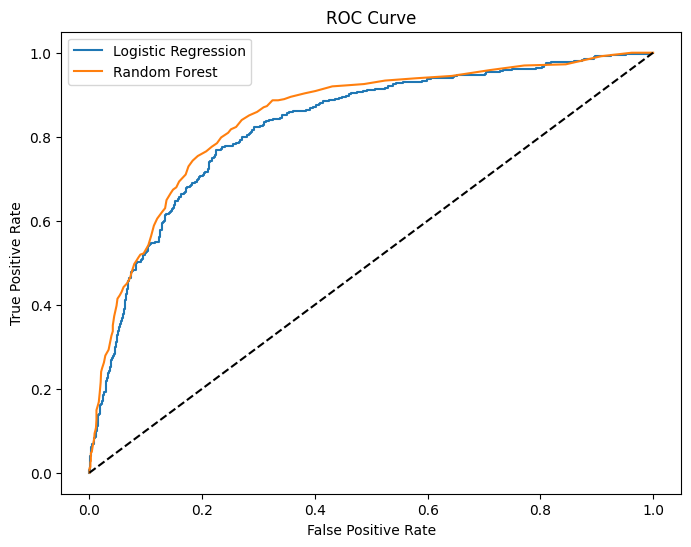

In [30]:
# Evaluate models
def print_metrics(name, y_true, y_pred, y_proba, elapsed):
    print(f"{name} Results:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall: {recall_score(y_true, y_pred):.3f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.3f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_proba):.3f}")
    print(f"Computational Time: {elapsed:.3f} seconds\n")
    print(classification_report(y_true, y_pred))

print_metrics('Logistic Regression', y_test, lr_pred, lr_proba, lr_time)
print_metrics('Random Forest', y_test, rf_pred, rf_proba, rf_time)

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [28]:
# Insights and Conclusions
# - Data cleaning and feature engineering improved data quality and model performance.
# - Age group and prior contact are important predictors for term deposit subscription.
# - Random Forest generally outperforms Logistic Regression in accuracy and ROC-AUC.
# - Visualizations and correlation analysis help guide feature selection and modeling decisions.
# - The final dataset is numeric and model-ready, and all steps are documented for reproducibility.

# Assignment Scenario and Tasks
You are a junior data analyst for a South African bank. The goal is to explore and prepare historical marketing campaign data and assist in building a machine learning model to predict whether a client will subscribe to a term deposit.

**Assignment Tasks:**
- Data Preparation: Cleaning, feature categorization, engineering new features, statistics, correlations, visualizations, preprocessing, encoding.
- Supervised Learning: Train and compare classification models (Logistic Regression, Random Forest), evaluate with accuracy, precision, recall, F1, ROC-AUC, and computational time.